In [1]:
# 基础库
import os                  # 操作系统接口,提供文件/目录操作功能
import platform           # 获取系统平台信息,如操作系统类型、版本等
import sys               # Python解释器接口,提供Python运行环境信息
from io import BytesIO    # 二进制I/O操作,处理内存中的字节流数据
from PIL import Image     # Python图像处理库,提供图像打开、编辑等功能
import requests          # HTTP库,用于发送网络请求和处理响应
import time          # 用于计算时间差
import pandas as pd

# 科学计算和机器学习
import numpy as np        # 数值计算库,提供多维数组和数学函数
import tensorflow as tf   # 深度学习框架,用于构建和训练神经网络模型

# 数据可视化
import matplotlib.pyplot as plt         # 绘图库,创建各类统计图表
from matplotlib.font_manager import FontProperties, fontManager  # 字体管理,支持中文显示

# Jupyter工具
from IPython.display import clear_output  # 清理notebook输出内容

# Kaggle工具
import kagglehub         # Kaggle数据集管理工具,用于下载和使用数据集

# 系统环境信息
print("Python version:", sys.version)     # Python解释器版本
print("Platform:", platform.platform())   # 完整的平台标识符
print("System:", platform.system())       # 操作系统名称
print("Node:", platform.node())           # 网络节点名称
print("Release:", platform.release())     # 操作系统发行版本
print("Version:", platform.version())     # 操作系统版本号
print("Machine:", platform.machine())     # 硬件架构类型
print("Processor:", platform.processor()) # CPU类型

# 检查依赖包信息
!pip show tensorflow                      # 显示TensorFlow包信息

# 系统硬件信息
!cat /proc/cpuinfo | grep 'model name'    # CPU型号信息
!cat /proc/meminfo | grep 'MemTotal'      # 系统内存大小
!df -h                                    # 磁盘使用情况
!nvidia-smi                               # GPU信息(如有)


Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
System: Linux
Node: 98565ed04f4d
Release: 6.1.123+
Version: #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
Machine: x86_64
Processor: x86_64
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal:       13289424 kB
Filesystem  

# 1.数据集获取

本项目使用的蘑菇图像数据集托管在 [Kaggle](https://www.kaggle.com/) 平台上，数据集名称为 [huizecai/mushroom](https://www.kaggle.com/datasets/huizecai/mushroom)。该数据集包含了多种常见蘑菇的高清图片，以及对应的分类标签。

为了方便数据获取，我们使用 `kagglehub` 库来自动下载和管理数据集。下面的代码单元格会直接从 Kaggle 下载数据集，并返回保存在本地的路径。数据集下载完成后会被缓存，后续运行时将直接使用缓存版本，无需重复下载。

In [2]:
# 设置数据集名称
dataset_name = "huizecai/mushroom/version/6"  # 指定要下载的Kaggle数据集名称

# 使用KaggleHub下载数据集
path = kagglehub.dataset_download(dataset_name)  # 下载数据集并获取保存路径

# 打印数据集文件的保存路径
print("Path to dataset files:", path)

label_path = path + "/datasets/label.txt"

train_dir = path + "/datasets/train_images"
val_dir = path + "/datasets/val_images"

100%|██████████| 932M/932M [00:43<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/huizecai/mushroom/versions/6


# 2.读取数据集label映射

In [3]:
# 读取 label.txt 并解析内容
# 创建一个空字典用于存储类别ID和名称的映射关系
categories = {}
# 以UTF-8编码打开label.txt文件
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        # 去除每行首尾空白字符并按空格分割
        parts = line.strip().split()
        # 确保每行包含两个部分:类别名称和ID
        if len(parts) == 2:
            category_name = parts[0]  # 第一部分为类别名称(中文)
            category_id = parts[1]    # 第二部分为类别ID
            categories[category_id] = category_name  # 建立ID到名称的映射

print("读取label.txt文件成功")
print("类别ID和名称的映射关系:", categories)

读取label.txt文件成功
类别ID和名称的映射关系: {'class00': '羊肚菌', 'class01': '牛肝菌', 'class02': '鸡油菌', 'class03': '鸡枞菌', 'class04': '青头菌', 'class05': '奶浆菌', 'class06': '干巴菌', 'class07': '虎掌菌', 'class08': '白葱牛肝菌', 'class09': '老人头菌', 'class10': '猪肚菌', 'class11': '谷熟菌', 'class12': '白参菌', 'class13': '黑木耳', 'class14': '银耳', 'class15': '金耳', 'class16': '猴头菇', 'class17': '香菇', 'class18': '平菇', 'class19': '金针菇', 'class20': '口蘑', 'class21': '鹿茸菇', 'class22': '榆黄蘑', 'class23': '榛蘑', 'class24': '草菇', 'class25': '鸡腿菇', 'class26': '茶树菇', 'class27': '蟹味菇', 'class28': '白玉菇', 'class29': '红菇', 'class30': '杏鲍菇', 'class31': '松茸', 'class32': '姬松茸', 'class33': '松露', 'class34': '竹荪', 'class35': '虫草花'}


# 3.解决matplotlib中文显示问题

matplotlib默认不支持中文字体显示,可能会出现乱码。为了确保数据可视化结果能正确展示中文:
1. 我们将下载并使用"SimHei"(黑体)字体
2. 注册字体到matplotlib的字体管理器
3. 配置全局字体设置

这样可以保证后续所有图表中的中文标题、标签等都能正常显示。

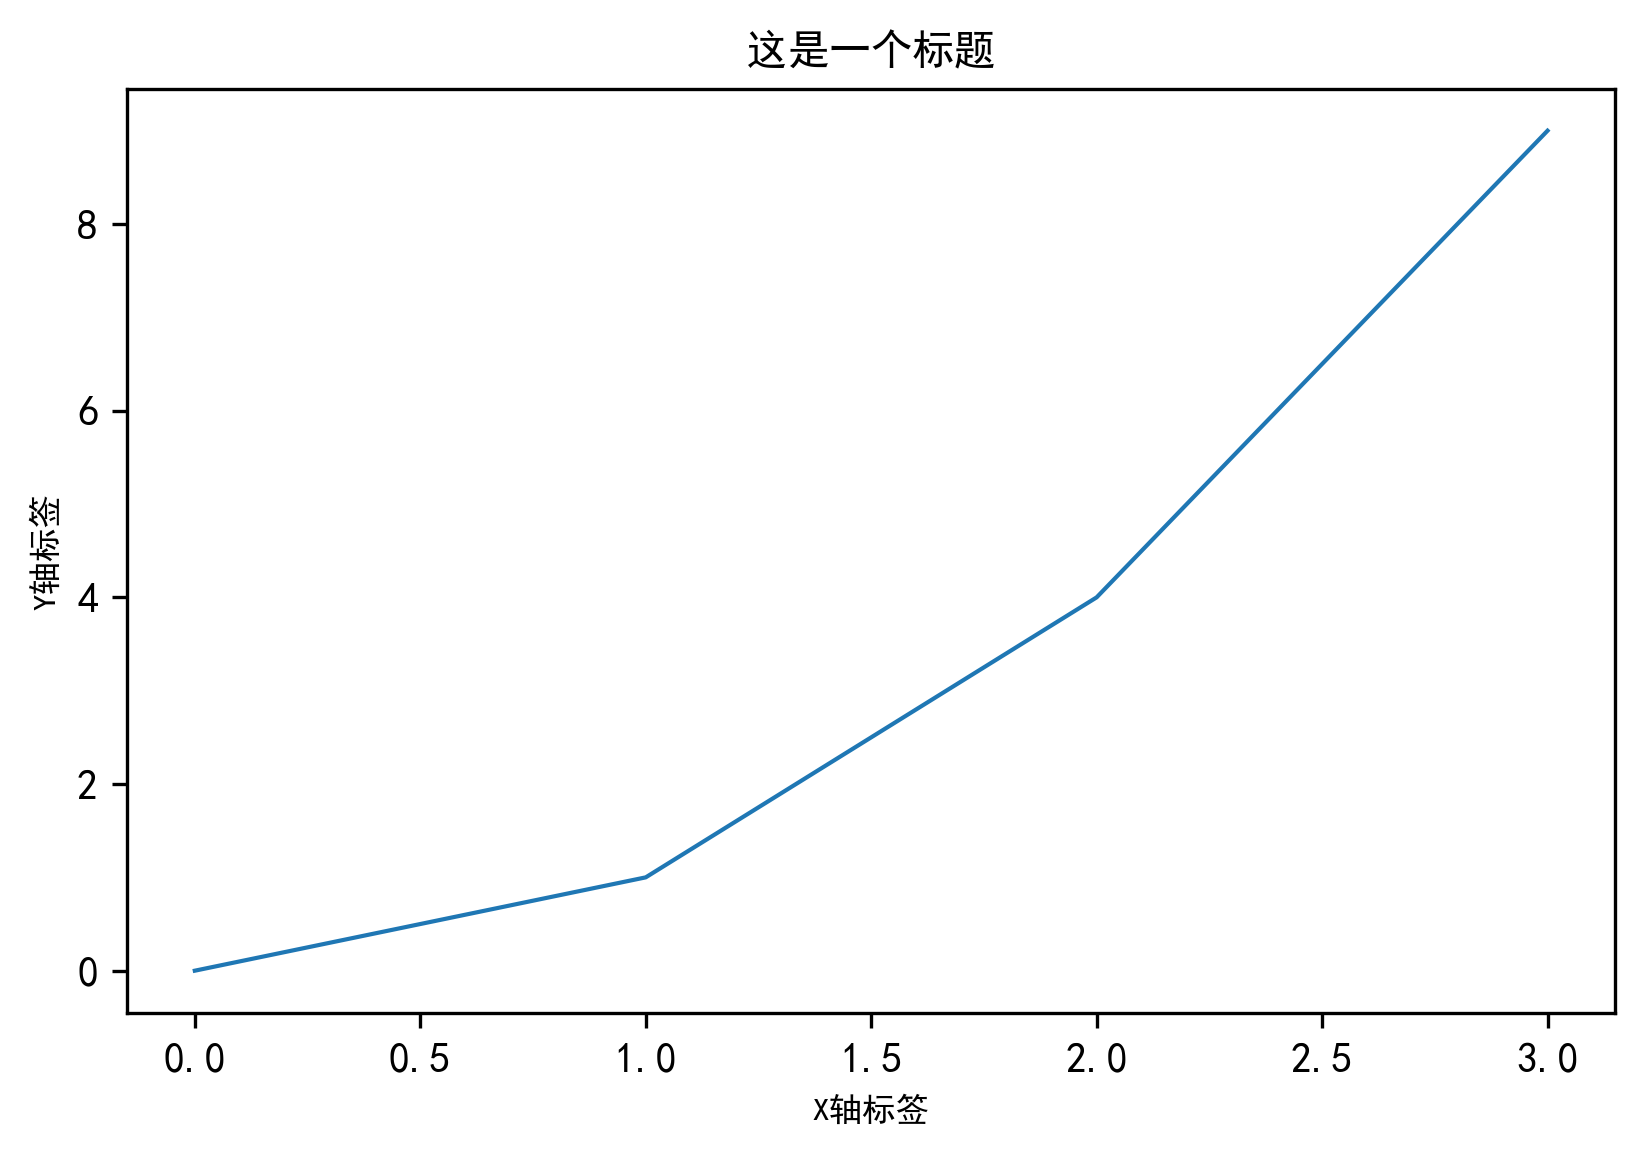

In [4]:
# 创建img目录(如果不存在)
if not os.path.exists('img'):
    os.makedirs('img')

# 设置字体文件的URL和本地保存路径
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"  # 黑体字体文件的URL
font_name = "SimHei.ttf"  # 本地保存的字体文件名

# 如果字体文件不存在则下载
if not os.path.exists(font_name):
    # 使用requests下载字体文件
    response = requests.get(font_url)
    # 检查请求是否成功
    if response.status_code == 200:
        # 将内容写入文件
        with open(font_name, 'wb') as f:
            f.write(response.content)
    else:
        print(f"下载字体文件失败,状态码: {response.status_code}")

# 配置matplotlib的字体设置
fontManager.addfont(font_name)  # 将字体文件添加到matplotlib的字体管理器
font_prop = FontProperties(fname=font_name)  # 创建字体属性对象

# 设置全局字体配置
plt.rcParams['font.family'] = 'SimHei'  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['font.size'] = 10  # 设置全局字体大小
plt.rcParams['axes.titlesize'] = 10  # 设置标题字体大小
plt.rcParams['axes.labelsize'] = 8  # 设置轴标签字体大小
plt.rcParams['figure.dpi'] = 300  # 设置图形DPI为300,提高显示清晰度
plt.rcParams['savefig.dpi'] = 600  # 设置保存图片的DPI为600,提高保存图片的清晰度

# 绘制测试图表验证中文显示
plt.figure(figsize=(6.4, 4))  # 设置图形大小
plt.title('这是一个标题', fontsize=10)  # 设置标题
plt.xlabel('X轴标签', fontsize=8)  # 设置X轴标签
plt.ylabel('Y轴标签', fontsize=8)  # 设置Y轴标签
plt.plot([0, 1, 2, 3], [0, 1, 4, 9], linewidth=1)  # 绘制简单的折线图,增加线宽提高清晰度

# 保存图表到img目录,使用更高质量的设置
plt.savefig('img/test_plot.png',
            bbox_inches='tight',  # 自动调整边界
            format='png',  # 使用PNG格式保存
            facecolor='white',  # 设置白色背景
            edgecolor='none',  # 无边框
            transparent=False)  # 不透明
plt.show()  # 显示图表

# 4.加载图像数据集

使用load_mushroom_dataset函数加载蘑菇分类数据集

参数:
- batch_size: 批次大小
- img_height: 图片高度
- img_width: 图片宽度

返回:
- train_ds: 训练数据集
- val_ds: 验证数据集
- class_names: 类别名称列表


In [5]:
img_height = 224
img_width = 224
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

# 配置数据集以提高性能
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 9118 files belonging to 36 classes.
Found 1139 files belonging to 36 classes.


# 5.模型训练相关函数定义
以下定义了用于模型训练的核心函数,包括:
- train_model: 训练深度学习模型的主函数,负责模型编译、配置回调函数和训练过程
- 回调函数:
  - early_stopping: 提前停止训练,防止过拟合
  - lr_scheduler: 动态调整学习率,优化训练效果
- 训练参数:
  - optimizer: adam优化器
  - loss: 分类交叉熵损失函数
  - metrics: 准确率评估指标

In [6]:
# 训练模型函数
def train_model(model, train_dataset=train_dataset, validation_dataset=validation_dataset, epochs=25):
    """
    训练深度学习模型的函数

    参数:
        model: 待训练的模型
        train_dataset: 训练数据集
        validation_dataset: 验证数据集
        epochs: 训练轮数,默认25轮

    返回:
        history: 训练历史记录,包含loss和accuracy等指标
    """
    # 配置模型训练参数
    # 使用adam优化器,交叉熵损失函数,准确率评估指标
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    # 配置回调函数
    # early_stopping: 当验证集loss在6轮内没有改善时停止训练,并恢复最佳权重
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    )
    """

    # lr_scheduler: 当验证集loss在3轮内没有改善时,学习率减半,最小到1e-7
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )

    # 开始训练
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=[lr_scheduler]
    )

    return history

# 6.模型量化和保存函数

为了在移动设备和嵌入式系统上高效部署模型,我们需要:
1. 将训练好的Keras模型量化 - 把权重从float32转为int8,显著减小模型大小
2. 转换为TFLite格式 - TFLite是专门为移动和嵌入式设备优化的轻量级框架
3. 保存模型到文件 - 以便后续部署使用

下面三个函数实现了这些功能:
- convert_to_tflite(): 将Keras模型转换为TFLite格式
- quantize_and_convert_to_tflite(): 模型量化和TFLite转换
- save_model(): 保存模型到文件


In [7]:
def convert_to_tflite(model):
    """
    将Keras模型转换为TFLite格式

    参数:
        model: Keras模型对象

    返回:
        tflite_model: 转换后的TFLite模型

    说明:
        - 使用TFLite转换器将Keras模型转换为TFLite格式
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    return tflite_model

def quantize_and_convert_to_tflite(model):
    """
    将Keras模型量化并转换为TFLite格式

    参数:
        model: Keras模型对象

    返回:
        tflite_quant_model: 量化后的TFLite模型

    说明:
        - 使用TFLite转换器将Keras模型转换为TFLite格式
        - 启用默认优化以减小模型大小和提高推理性能
        - 量化可以将模型权重从float32转换为int8,显著减小模型大小
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant_model = converter.convert()

    return tflite_quant_model

def save_model(model, output_path):
    """
    保存模型到文件

    参数:
        model: 要保存的模型对象
        output_path: 保存模型的文件路径

    说明:
        - 以二进制格式写入模型到指定路径
        - 通常用于保存TFLite模型(.tflite文件)
    """
    with open(output_path, 'wb') as f:
        f.write(model)

# 7.可视化训练历史

下面的函数用于可视化模型训练过程中的指标变化:

- show_history(): 绘制训练历史中的损失和准确率曲线
  - 创建1x2的子图布局
  - 左图显示训练和验证损失
  - 右图显示训练和验证准确率
  - 使用matplotlib进行绘图



In [8]:
def show_history(history):
    """
    可视化模型训练历史中的损失和准确率曲线

    参数:
        history: 模型训练返回的History对象,包含训练过程中的指标数据

    功能:
        - 创建一个1x2的子图布局
        - 左图显示训练集和验证集的损失曲线
        - 右图显示训练集和验证集的准确率曲线
        - 自动调整布局并显示图形

    返回:
        无返回值,直接显示图形
    """
    # 创建12x4英寸的画布
    plt.figure(figsize=(6.4, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 自动调整子图布局
    plt.tight_layout()
    # 显示图形
    plt.show()

# 8.模型评估函数

In [9]:
def evaluate_model(model, dataset):
    """使用TensorFlow内置metrics评估Keras模型在数据集上的性能

    Args:
        model: Keras模型对象
        dataset: tf.data.Dataset数据集对象

    Returns:
        tuple: (top1准确率, top5准确率, 模型大小, 推理速度)
    """
    # 计算模型大小 (MB)
    model_size_mb = sum(np.prod(w.shape) for w in model.get_weights()) * 4 / (1024 * 1024)

    # 创建评估指标
    top1_accuracy = tf.keras.metrics.CategoricalAccuracy()  # Top-1准确率评估器
    top5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')  # Top-5准确率评估器

    # 创建损失函数和平均损失计算器
    loss_object = tf.keras.losses.CategoricalCrossentropy()  # 分类交叉熵损失函数
    loss_avg = tf.keras.metrics.Mean()  # 用于计算平均损失

    # 记录推理时间
    total_time = 0
    total_samples = 0

    # 在数据集上运行评估
    for images, labels in dataset:
        start_time = time.time()
        predictions = model(images, training=False)  # 获取模型预测结果
        end_time = time.time()

        # 累计推理时间和样本数
        total_time += end_time - start_time
        total_samples += len(images)

        loss = loss_object(labels, predictions)  # 计算损失值

        # 更新评估指标
        loss_avg.update_state(loss)
        top1_accuracy.update_state(labels, predictions)
        top5_accuracy.update_state(labels, predictions)

    # 计算平均推理速度 (ms/sample)
    avg_inference_time = (total_time / total_samples) * 1000

    # 获取最终评估结果
    loss = loss_avg.result().numpy()
    top1 = top1_accuracy.result().numpy()
    top5 = top5_accuracy.result().numpy()

    # 打印评估结果
    print(f"Loss: {loss:.4f}")
    print(f"Top-1 Accuracy: {top1:.4f}")
    print(f"Top-5 Accuracy: {top5:.4f}")
    print(f"Model Size: {model_size_mb:.2f} MB")
    print(f"Average Inference Time: {avg_inference_time:.2f} ms/sample")

    return top1, top5, model_size_mb, avg_inference_time

def evaluate_tflite_model(tflite_model, dataset):
    """评估TFLite模型的性能

    Args:
        tflite_model: TFLite模型的二进制内容
        dataset: tf.data.Dataset数据集对象

    Returns:
        tuple: (top1准确率, top5准确率, 模型大小, 推理速度)
    """
    # 计算TFLite模型大小 (MB)
    model_size_mb = len(tflite_model) / (1024 * 1024)

    # 创建并初始化TFLite解释器
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # 获取模型输入输出张量的详细信息
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # 创建评估指标
    top1_accuracy = tf.keras.metrics.Accuracy()  # Top-1准确率评估器
    top5_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)  # Top-5准确率评估器

    total_samples = 0  # 样本计数器
    total_time = 0  # 总推理时间

    # 遍历数据集进行评估
    for images, labels in dataset:
        # 将one-hot标签转换为类别索引
        true_labels = tf.argmax(labels, axis=1).numpy()

        batch_size = images.shape[0]
        # 存储批次预测结果的数组
        batch_predictions = np.zeros((batch_size, 36), dtype=np.float32)

        # 对批次中的每个样本进行推理
        for i in range(batch_size):
            total_samples += 1

            # 预处理输入数据
            input_data = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)

            # 记录推理时间
            start_time = time.time()

            # 设置输入数据并运行推理
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()

            # 获取预测结果
            batch_predictions[i] = interpreter.get_tensor(output_details[0]['index'])[0]

            end_time = time.time()
            total_time += end_time - start_time

        # 更新评估指标
        top1_accuracy.update_state(
            true_labels,
            np.argmax(batch_predictions, axis=1)
        )
        top5_accuracy.update_state(
            true_labels,
            batch_predictions
        )

    # 计算平均推理速度 (ms/sample)
    avg_inference_time = (total_time / total_samples) * 1000

    # 获取最终评估结果
    top1 = top1_accuracy.result().numpy()
    top5 = top5_accuracy.result().numpy()

    # 打印评估结果
    print(f"TFLite模型 Top-1 准确率: {top1:.4f}")
    print(f"TFLite模型 Top-5 准确率: {top5:.4f}")
    print(f"TFLite模型大小: {model_size_mb:.2f} MB")
    print(f"TFLite模型平均推理时间: {avg_inference_time:.2f} ms/sample")

    return top1, top5, model_size_mb, avg_inference_time

# 9.MobileNetV1模型

In [10]:
def get_MobileNetV1():
  """
  构建并返回一个基于MobileNetV1的迁移学习模型

  模型架构:
  1. 使用预训练的MobileNetV1作为特征提取器
  2. 添加数据增强层进行训练时的数据增强
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的MobileNetV1模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.MobileNet(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 预处理
  x = tf.keras.applications.mobilenet.preprocess_input(pre_trained_model.input)  # MobileNet专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(36, activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  MobileNetV1 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV1

# 10.MobileNetV2模型

In [11]:
def get_MobileNetV2():
  """
  构建并返回一个基于MobileNetV2的迁移学习模型

  模型架构:
  1. 使用预训练的MobileNetV2作为特征提取器
  2. 添加数据增强层进行训练时的数据增强
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的MobileNetV2模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.MobileNetV2(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 预处理
  x = tf.keras.applications.mobilenet_v2.preprocess_input(pre_trained_model.input)  # MobileNetV2专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(36, activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  MobileNetV2 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV2

# 11.EfficientNet模型

In [12]:
def get_EfficientNetB0():
  """
  构建并返回一个基于EfficientNetB0的迁移学习模型

  模型架构:
  1. 使用预训练的EfficientNetB0作为特征提取器,该模型在ImageNet数据集上预训练
  2. 添加数据增强层提高模型泛化能力
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的EfficientNetB0模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.EfficientNetB0(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 预处理
  x = tf.keras.applications.efficientnet.preprocess_input(pre_trained_model.input)  # EfficientNet专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(36, activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  EfficientNetB0 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return EfficientNetB0

# 12.ResNet模型

In [13]:
def get_ResNet101():
  """
  构建并返回一个基于ResNet101的迁移学习模型

  模型架构:
  1. 使用预训练的ResNet101作为特征提取器,该模型在ImageNet数据集上预训练
  2. 添加数据增强层提高模型泛化能力
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的ResNet101模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.ResNet101(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 预处理
  x = tf.keras.applications.resnet.preprocess_input(pre_trained_model.input)  # ResNet专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(36, activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  ResNet101 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return ResNet101

# 13.训练

In [14]:
# 获取MobileNetV1模型
MobileNetV1 = get_MobileNetV1()

# 训练MobileNetV1模型并保存训练历史
history_MobileNetV1 = train_model(MobileNetV1)

# 模型转换为TFLite格式
MobileNetV1_tflite = convert_to_tflite(MobileNetV1)

# 将模型量化并转换为TFLite格式以便部署
MobileNetV1_quantize_tflite = quantize_and_convert_to_tflite(MobileNetV1)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.1967 - loss: 3.0329 - val_accuracy: 0.5838 - val_loss: 1.4859 - learning_rate: 0.0010
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5249 - loss: 1.6483 - val_accuracy: 0.6550 - val_loss: 1.2328 - learning_rate: 0.0010
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5896 - loss: 1.3975 - val_accuracy: 0.6673 - val_loss: 1.1724 - learning_rate: 0.0010
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6182 - loss: 1.2709 - val_accuracy: 0.6725 - val_loss: 1.1219 - learning_rate: 0.0010
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6514 - loss: 1.1605 - val_accuracy: 0.6822 - val_loss: 1.1241 - learning_rate: 0.0010
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6833 - loss: 1.0574 - val_accuracy: 0.6989 - val_loss: 1.0910 - learning_rate: 0.0010
Epoch 7/40
285/285 ━━━━━━━

In [15]:
# 获取MobileNetV2模型
MobileNetV2 = get_MobileNetV2()

# 训练MobileNetV2模型并保存训练历史
history_MobileNetV2 = train_model(MobileNetV2)

# 模型转换为TFLite格式
MobileNetV2_tflite = convert_to_tflite(MobileNetV2)

# 将模型量化并转换为TFLite格式以便部署
MobileNetV2_quantize_tflite = quantize_and_convert_to_tflite(MobileNetV2)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.2427 - loss: 2.7939 - val_accuracy: 0.6374 - val_loss: 1.3265 - learning_rate: 0.0010
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.5711 - loss: 1.4643 - val_accuracy: 0.6637 - val_loss: 1.1794 - learning_rate: 0.0010
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6395 - loss: 1.2347 - val_accuracy: 0.6874 - val_loss: 1.1266 - learning_rate: 0.0010
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6702 - loss: 1.0967 - val_accuracy: 0.6971 - val_loss: 1.0852 - learning_rate: 0.0010
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6962 - loss: 1.0062 - val_accuracy: 0.7041 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7254 - loss: 0.9033 - val_accuracy: 0.7103 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 7/40
285/285 ━━━━━━━━━━━

In [16]:
# 获取EfficientNetB0模型
EfficientNetB0 = get_EfficientNetB0()

# 训练EfficientNetB0模型并保存训练历史
history_EfficientNetB0 = train_model(EfficientNetB0)

# 模型转换为TFLite格式
EfficientNetB0_tflite = convert_to_tflite(EfficientNetB0)

# 将模型量化并转换为TFLite格式以便部署
EfficientNetB0_quantize_tflite = quantize_and_convert_to_tflite(EfficientNetB0)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - accuracy: 0.2968 - loss: 2.6454 - val_accuracy: 0.6980 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6458 - loss: 1.2272 - val_accuracy: 0.7305 - val_loss: 0.9645 - learning_rate: 0.0010
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7052 - loss: 1.0130 - val_accuracy: 0.7313 - val_loss: 0.9254 - learning_rate: 0.0010
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7347 - loss: 0.8900 - val_accuracy: 0.7313 - val_loss: 0.9011 - learning_rate: 0.0010
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7526 - loss: 0.8011 - val_accuracy: 0.7498 - val_loss: 0.8871 - learning_rate: 0.0010
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7587 - loss: 0.7455 - val_accuracy: 0.7533 - val_loss: 0.8699 - learning_rate: 0.0010
Epoch 7/40
285/285 ━━━━━

In [ ]:
# 获取ResNet101模型
ResNet101 = get_ResNet101()

# 训练ResNet101模型并保存训练历史
history_ResNet101 = train_model(ResNet101)

# 模型转换为TFLite格式
ResNet101_tflite = convert_to_tflite(ResNet101)

# 将模型量化并转换为TFLite格式以便部署
ResNet101_quantize_tflite = quantize_and_convert_to_tflite(ResNet101)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 90s 225ms/step - accuracy: 0.2749 - loss: 2.7421 - val_accuracy: 0.6655 - val_loss: 1.1957 - learning_rate: 0.0010
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 45s 160ms/step - accuracy: 0.6006 - loss: 1.3489 - val_accuracy: 0.7015 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - accuracy: 0.6715 - loss: 1.1128 - val_accuracy: 0.7234 - val_loss: 1.0207 - learning_rate: 0.0010
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 46s 162ms/step - accuracy: 0.7139 - loss: 0.9479 - val_accuracy: 0.7182 - val_loss: 1.0441 - learning_rate: 0.0010
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - accuracy: 0.7471 - loss: 0.8315 - val_accuracy: 0.7252 - val_loss: 1.0211 - learning_rate: 0.0010
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 46s 162ms/step - accuracy: 0.7751 - loss: 0.7148 - val_accuracy: 0.7419 - val_loss: 0.9623 - learning_rate: 5.0000e-04
Epoch 7/40
28

# 14.保存训练数据

In [1]:
def save_history_to_csv(history, filename='history.csv'):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    pd.DataFrame(history.history).to_csv(filename, index=False)
    print(f"训练历史已保存到: {filename}")

# 使用方法
save_history_to_csv(history_MobileNetV1, 'csv/history_MobileNetV1.csv')
save_history_to_csv(history_MobileNetV2, 'csv/history_MobileNetV2.csv')
save_history_to_csv(history_EfficientNetB0, 'csv/history_EfficientNetB0.csv')
save_history_to_csv(history_ResNet101, 'csv/history_ResNet101.csv')

os.system(f'zip -r step3_return_csv.zip csv')

NameError: name 'history_MobileNetV1' is not defined

In [ ]:
# 合并所有模型的训练历史数据并可视化比较

# 设置全局样式参数
TITLE_SIZE = 12
LABEL_SIZE = 10
LEGEND_SIZE = 10
LINE_WIDTH = 1
FIG_SIZE = (6.4, 4)
DPI = 600
TICK_SIZE = 8  # 新增坐标轴刻度文字大小参数

In [ ]:
# 绘制训练准确率对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['accuracy'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['accuracy'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['accuracy'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['accuracy'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('训练准确率对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('准确率', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/training_accuracy.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [ ]:
# 绘制验证准确率对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['val_accuracy'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['val_accuracy'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['val_accuracy'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['val_accuracy'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('验证准确率对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('准确率', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/validation_accuracy.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [ ]:
# 绘制训练损失对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['loss'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['loss'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['loss'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['loss'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('训练损失对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('损失', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/training_loss.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [ ]:
# 绘制验证损失对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['val_loss'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['val_loss'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['val_loss'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['val_loss'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('验证损失对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('损失', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/validation_loss.png', dpi=DPI, bbox_inches='tight')
plt.show()

# 14.保存模型

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

MobileNetV1.save("models/MobileNetV1.keras")
save_model(MobileNetV1_tflite, "models/MobileNetV1.tflite")
save_model(MobileNetV1_quantize_tflite, "models/MobileNetV1_quantize.tflite")

MobileNetV2.save("models/MobileNetV2.keras")
save_model(MobileNetV2_tflite, "models/MobileNetV2.tflite")
save_model(MobileNetV2_quantize_tflite, "models/MobileNetV2_quantize.tflite")

EfficientNetB0.save("models/EfficientNetB0.keras")
save_model(EfficientNetB0_tflite, "models/EfficientNetB0.tflite")
save_model(EfficientNetB0_quantize_tflite, "models/EfficientNetB0_quantize.tflite")

ResNet101.save("models/ResNet101.keras")
save_model(ResNet101_tflite, "models/ResNet101.tflite")
save_model(ResNet101_quantize_tflite, "models/ResNet101_quantize.tflite")

!zip -r models.zip models

# 14.评估

本节将对训练好的模型进行评估,包括:
1. 评估原始模型在验证集上的性能指标(准确率等)
2. 评估量化后的TFLite模型在验证集上的性能指标
3. 将量化后的TFLite模型保存到文件中以便部署

我们将依次评估以下4个模型:
- MobileNetV1: 轻量级CNN模型,适合移动端部署
- MobileNetV2: MobileNetV1的改进版本,性能更好
- EfficientNetB0: 高效CNN模型,在准确率和效率之间取得平衡
- ResNet101: 经典的深度残差网络,性能强大但计算量较大

In [ ]:
# 评估并保存MobileNetV1模型
print("MobileNetV1:\n")
# 评估原始模型在验证集上的性能
evaluate_model(MobileNetV1, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV1_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV1_quantize_tflite, validation_dataset)

# 评估并保存MobileNetV2模型
print("\nMobileNetV2:\n")
# 评估原始模型在验证集上的性能
evaluate_model(MobileNetV2, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV2_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV2_quantize_tflite, validation_dataset)

# 评估并保存EfficientNetB0模型
print("\nEfficientNetB0:\n")
# 评估原始模型在验证集上的性能
evaluate_model(EfficientNetB0, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(EfficientNetB0_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(EfficientNetB0_quantize_tflite, validation_dataset)

# 评估并保存ResNet101模型
print("\nResNet101:\n")
# 评估原始模型在验证集上的性能
evaluate_model(ResNet101, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(ResNet101_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(ResNet101_quantize_tflite, validation_dataset)

# 使用图片测试模型

下面的代码定义了两个主要函数:
1. preprocess_image(): 图像预处理函数
   - 从URL下载图片并进行预处理
   - 调整图片大小、处理通道数等
   - 返回预处理后的图片数组和原始图片对象
2. predict_top_k_from_url(): 模型预测函数
   - 使用预处理函数处理输入图片
   - 使用模型进行预测
   - 返回前k个最可能的预测类别及其置信度


In [ ]:
# 图像预处理函数
# 输入:
#   - image_url: 图片URL链接
#   - target_size: 目标图片大小,默认(224,224)
# 输出:
#   - image_array: 预处理后的图片数组,形状为(1, height, width, channels)
#   - image: 原始PIL图片对象
def preprocess_image(image_url, target_size=(224, 224)):
    # 从URL下载图片
    response = requests.get(image_url)
    if response.status_code != 200:
        raise ValueError("无法从链接加载图像，请检查链接是否有效！")

    # 将图片转换为PIL对象并调整大小
    image = Image.open(BytesIO(response.content))
    image = image.resize(target_size)

    # 转换为numpy数组
    image_array = np.array(image)

    # 处理灰度图,转换为3通道
    if image_array.shape[-1] != 3:
        image_array = np.stack((image_array,) * 3, axis=-1)

    # 扩展维度以匹配模型输入要求
    image_array = np.expand_dims(image_array, axis=0)
    return image_array, image

# 预测函数,输出前k个预测结果
# 输入:
#   - model: 训练好的模型
#   - image_url: 图片URL链接
#   - class_names: 类别名称列表
#   - top_k: 返回前k个预测结果,默认10
# 输出:
#   - top_k_labels: 前k个预测类别
#   - top_k_confidences: 前k个预测置信度
def predict_top_k_from_url(model, image_url, class_names, top_k=10):
    # 预处理图像
    image_array, original_image = preprocess_image(image_url)

    # 使用模型进行预测
    predictions = model.predict(image_array)[0]  # 获取预测结果

    # 获取前k个最高概率的索引
    top_k_indices = np.argsort(predictions)[::-1][:top_k]

    # 获取对应的类别名称和置信度
    top_k_labels = [class_names[i] for i in top_k_indices]
    top_k_confidences = [predictions[i] * 100 for i in top_k_indices]  # 转换为百分比

    # 可视化原始图片
    plt.imshow(original_image)
    plt.title("Top Predictions")
    plt.axis("off")
    plt.show()
    print(image_array)

    # 打印预测结果
    print("Top Predictions:")
    for label, confidence in zip(top_k_labels, top_k_confidences):
        print(f"  {label}: {confidence:.2f}%")

    return top_k_labels, top_k_confidences

# 测试示例
# 使用一张测试图片进行预测
image_url = "https://th.bing.com/th/id/OIP.zNnwH-t-xEer_nd7gt2qLAHaFj?w=1620&h=1215&rs=1&pid=ImgDetMain"

# 获取前10个预测结果
top_k_labels, top_k_confidences = predict_top_k_from_url(model, image_url, train_dataset.class_names, top_k=10)